<h1 class='font-effect-3d' style='font-family:Ewert; color:#ff603b;'>Modules, Helpful Functions, & Styling</h1>

In [1]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Ewert|Aladin&effect=3d');
span {color:black; text-shadow:3px 3px 3px #aaa;}  
div.output_area pre{font-family:Aladin; font-size:110%; color:#ff603b;}      
</style>

In [2]:
import warnings; warnings.filterwarnings('ignore')
import h5py,urllib,pylab as pl,seaborn as sn
import numpy as np,pandas as pd
import tensorflow_hub as th,tensorflow as tf
import tensorflow.keras.layers as tkl
from IPython.display import display,HTML
import PIL.Image as pimg
data_path='https://raw.githubusercontent.com/'+\
          'OlgaBelitskaya/data_kitchen/main/'
url_path='https://olgabelitskaya.gitlab.io/images/'
file_path='../input/image-examples-for-mixed-styles/'
file_path2='../input/flower-color-images/'
hub_path='https://tfhub.dev/google/magenta/'+\
         'arbitrary-image-stylization-v1-256/1'
hub_path2='https://tfhub.dev/google/faster_rcnn/'+\
          'openimages_v4/inception_resnet_v2/1'
model_weights='/tmp/checkpoint'
col='#ff603b'

In [3]:
def get_file(file,url_path=url_path):
    input_file=urllib.request.urlopen(url_path+file)
    output_file=open(file,'wb'); 
    output_file.write(input_file.read())
    output_file.close(); input_file.close()
def prepro(x_train,y_train,x_test,y_test):
    n=int(len(x_test)/2)
    x_valid,y_valid=x_test[:n],y_test[:n]
    x_test,y_test=x_test[n:],y_test[n:]
    df=pd.DataFrame([[x_train.shape,x_valid.shape,x_test.shape],
                     [y_train.shape,y_valid.shape,y_test.shape]],
                    columns=['train','valid','test'],
                    index=['images','labels'])
    display(df)
    return [[x_train,x_valid,x_test],
            [y_train,y_valid,y_test]]
def load_img(path2img,max_dim=512):
    img=tf.io.read_file(path2img)
    img=tf.image.decode_image(img,channels=3)
    img=tf.image.convert_image_dtype(img,tf.float32)
    shape=tf.cast(tf.shape(img)[:-1],tf.float32)
    scale=max_dim/max(shape)
    new_shape=tf.cast(shape*scale,tf.int32)
    img=tf.image.resize(img,new_shape)
    return img[tf.newaxis,:]
def tensor2img(tensor):
    tensor=np.array(tensor*255,dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0]==1
        tensor=tensor[0]
    return pimg.fromarray(tensor)

<h1 class='font-effect-3d' style='font-family:Ewert; color:#ff603b;'>Data Loading & Preprocessing</h1>

In [4]:
(x_train1,y_train1),(x_test1,y_test1)=\
tf.keras.datasets.cifar10.load_data()
[[x_train1,x_valid1,x_test1],
 [y_train1,y_valid1,y_test1]]=\
prepro(x_train1,y_train1,x_test1,y_test1)

170500096/170498071 [==============================] - 5s 0us/step


,train,valid,test
images,"(50000, 32, 32, 3)","(5000, 32, 32, 3)","(5000, 32, 32, 3)"
labels,"(50000, 1)","(5000, 1)","(5000, 1)"


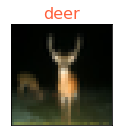

In [5]:
cifar_classes=['airplane','automobile','bird','cat','deer',
              'dog','frog','horse','ship','truck']
num_classes1=len(cifar_classes); img_size1=x_train1.shape[1]
n=np.random.randint(0,x_train1.shape[0])
pl.figure(figsize=(2,2)); pl.xticks([]); pl.yticks([])
pl.title(cifar_classes[y_train1[n][0]],fontsize=16,color=col)
pl.imshow(x_train1[n]); pl.tight_layout();

In [6]:
data_file='Flowers128.h5'
get_file(data_file,data_path)
with h5py.File(data_file,'r') as f:
    keys=list(f.keys())
    print('h5py.File keys: '+', '.join(keys))
    images=np.array(f[keys[0]])
    labels=np.array(f[keys[1]])
    names=[el.decode('utf-8')for el in f[keys[2]]]
    f.close()

h5py.File keys: images, labels, names


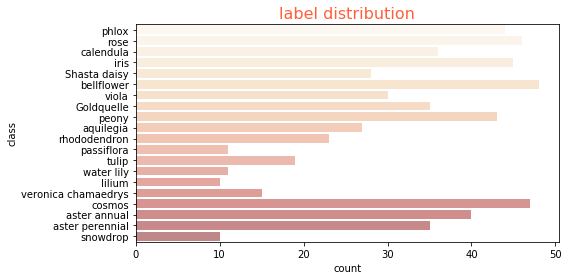

In [7]:
df=pd.DataFrame(labels,columns=['label'])
df['class']=[names[l] for l in labels]
pl.figure(figsize=(8,4))
sn.countplot(y='class',data=df,palette='OrRd',alpha=.5)
ti='label distribution'
pl.title(ti,fontsize=16,color=col)
pl.tight_layout(); pl.show()

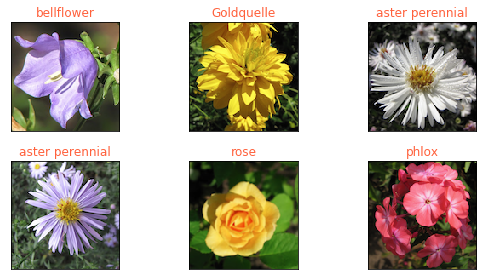

,train,valid,test
image shape,"(483, 128, 128, 3)","(60, 128, 128, 3)","(60, 128, 128, 3)"
image type,float32,float32,float32
label shape,"(483,)","(60,)","(60,)"
label type,int32,int32,int32


In [8]:
N=labels.shape[0]; n=int(.1*N); shuffle_ids=np.arange(N)
np.random.RandomState(12).shuffle(shuffle_ids)
images=images[shuffle_ids]; labels=labels[shuffle_ids]
num_classes2=len(names); img_size2=images.shape[1]
x_test2,x_valid2,x_train2=images[:n],images[n:2*n],images[2*n:]
y_test2,y_valid2,y_train2=labels[:n],labels[n:2*n],labels[2*n:]
df=pd.DataFrame(
    [[x_train2.shape,x_valid2.shape,x_test2.shape],
     [x_train2.dtype,x_valid2.dtype,x_test2.dtype],
     [y_train2.shape,y_valid2.shape,y_test2.shape],
     [y_train2.dtype,y_valid2.dtype,y_test2.dtype]],
    columns=['train','valid','test'],
    index=['image shape','image type','label shape','label type'])
fig=pl.figure(figsize=(8,4)); n=np.random.randint(1,100)
for i in range(n,n+6):
    ax=fig.add_subplot(2,3,i-n+1,xticks=[],yticks=[])
    ax.set_title(
        names[labels[i]],color=col,
        fontdict={'fontsize':'large'})
    ax.imshow((images[i]))
pl.tight_layout(); pl.show(); display(df)

<h1 class='font-effect-3d' style='font-family:Ewert; color:#ff603b;'>Fast Examples</h1>

40960/35363 [==================================] - 0s 0us/step
('crane', 0.1491689)
('lakeside', 0.11947847)
('pirate', 0.072678655)
('missile', 0.052838102)
('wreck', 0.0494856)


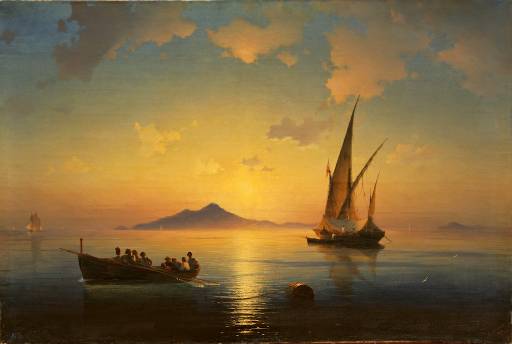

In [9]:
origin_img=load_img(file_path+'picture02.png')
x=tf.keras.applications.vgg19\
.preprocess_input(origin_img*255)
x=tf.image.resize(x,(224,224))
vgg19=tf.keras.applications\
.VGG19(include_top=True,weights='imagenet')
prediction_probabilities=vgg19(x)
predicted_top5=tf.keras.applications.vgg19\
.decode_predictions(prediction_probabilities.numpy())[0]
[print((class_name,prob)) 
 for (number,class_name,prob) in predicted_top5]
tensor2img(origin_img)

In [10]:
detector=th.load(hub_path2).signatures['default']
result=detector(origin_img)
df=pd.DataFrame.from_dict(
    {key:list(value.numpy()) for key,value in result.items()})
df.head(10)

,detection_class_labels,detection_class_entities,detection_class_names,detection_boxes,detection_scores
0,43,b'Boat',b'/m/019jd',"[0.29952112, 0.5924163, 0.74805236, 0.76745594]",0.990719
1,43,b'Boat',b'/m/019jd',"[0.7030217, 0.13640721, 0.8311358, 0.41028842]",0.987773
2,43,b'Boat',b'/m/019jd',"[0.6174392, 0.050232016, 0.6754843, 0.083202004]",0.674246
3,69,b'Person',b'/m/01g317',"[0.7364808, 0.35302752, 0.7899943, 0.38944015]",0.534796
4,69,b'Person',b'/m/01g317',"[0.7283155, 0.26366124, 0.7798278, 0.2972114]",0.234855
5,69,b'Person',b'/m/01g317',"[0.7192613, 0.22345732, 0.7500289, 0.23446651]",0.186842
6,69,b'Person',b'/m/01g317',"[0.7451333, 0.33265263, 0.7898813, 0.352525]",0.165312
7,69,b'Person',b'/m/01g317',"[0.71560574, 0.22079243, 0.7524597, 0.23752166]",0.140101
8,69,b'Person',b'/m/01g317',"[0.72288543, 0.23501985, 0.77685547, 0.2882685]",0.134404
9,69,b'Person',b'/m/01g317',"[0.74458724, 0.31290686, 0.7921808, 0.34788445]",0.127150


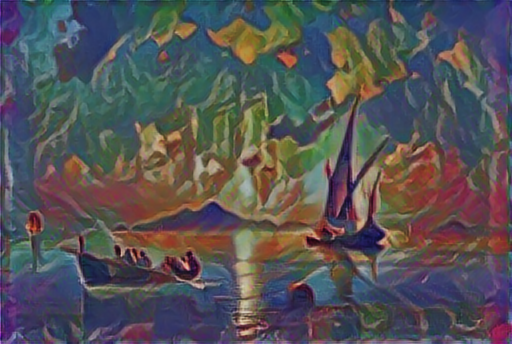

In [11]:
origin='06_001.png'; style='02_014.png'
def origin2style(origin,style,hub_path):
    get_file(origin); get_file(style)
    hub_module=th.load(hub_path)
    origin_img=load_img(origin); style_img=load_img(style)
    stylized_img=hub_module(
        tf.constant(origin_img),tf.constant(style_img))[0]
    display(tensor2img(stylized_img))
origin2style(origin,style,hub_path)

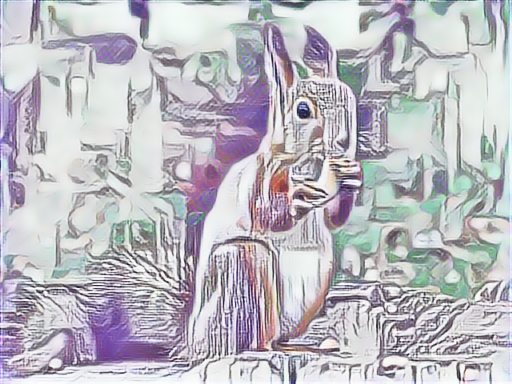

In [12]:
origin='01_016.png'; style='02_018.png'
origin2style(origin,style,hub_path)

<h1 class='font-effect-3d' style='font-family:Ewert; color:#ff603b;'>Simple Models </h1>

In [13]:
def cb(model_weights):
    early_stopping=tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',patience=20,verbose=2)
    checkpointer=tf.keras.callbacks.ModelCheckpoint(
filepath=model_weights,verbose=int(2),save_weights_only=True,
    monitor='val_accuracy',mode='max',save_best_only=True)
    lr_reduction=tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',verbose=2,patience=7,factor=.8)
    return [checkpointer,early_stopping,lr_reduction]

<h2 style='font-family:Aladin; color:#ff603b;'>MLP</h2>

In [14]:
def mlp_model(img_size,num_classes):
    model=tf.keras.models.Sequential([
        tkl.Flatten(input_shape=(img_size,img_size,3)),
        tkl.Dense(128),tkl.LeakyReLU(alpha=.02),
        tkl.BatchNormalization(),    
        tkl.Dense(256),tkl.LeakyReLU(alpha=.02),
        tkl.BatchNormalization(),    
        tkl.Dense(512),tkl.LeakyReLU(alpha=.02),
        tkl.BatchNormalization(),   
        tkl.Dense(1024),tkl.LeakyReLU(alpha=.02),
        tkl.Dropout(.2),
        tkl.Dense(num_classes,activation='softmax')])
    model.compile(optimizer='nadam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [15]:
model=mlp_model(img_size1,num_classes1)
model.fit(x_train1,y_train1,epochs=50,batch_size=16,
          validation_data=(x_valid1,y_valid1),
          callbacks=cb(model_weights));

Train on 50000 samples, validate on 5000 samples
Epoch 1/50
49952/50000 [============================>.] - ETA: 0s - loss: 1.8887 - accuracy: 0.3419
Epoch 00001: val_accuracy improved from -inf to 0.36100, saving model to /tmp/checkpoint
50000/50000 [==============================] - 21s 410us/sample - loss: 1.8886 - accuracy: 0.3420 - val_loss: 1.9025 - val_accuracy: 0.3610
Epoch 2/50
49840/50000 [============================>.] - ETA: 0s - loss: 1.6663 - accuracy: 0.4045
Epoch 00002: val_accuracy improved from 0.36100 to 0.42340, saving model to /tmp/checkpoint
50000/50000 [==============================] - 18s 367us/sample - loss: 1.6661 - accuracy: 0.4044 - val_loss: 1.6317 - val_accuracy: 0.4234
Epoch 3/50
49888/50000 [============================>.] - ETA: 0s - loss: 1.6088 - accuracy: 0.4259
Epoch 00003: val_accuracy did not improve from 0.42340
50000/50000 [==============================] - 18s 358us/sample - loss: 1.6087 - accuracy: 0.4260 - val_loss: 1.7159 - val_accuracy: 0.

In [16]:
model.load_weights(model_weights)
model.evaluate(x_test1,y_test1,verbose=0)

[1.5628146102905274, 0.551]

In [17]:
model=mlp_model(img_size2,num_classes2)
model.fit(x_train2,y_train2,epochs=50,batch_size=64,
          validation_data=(x_valid2,y_valid2),
          callbacks=cb(model_weights))

Train on 483 samples, validate on 60 samples
Epoch 1/50
256/483 [==============>...............] - ETA: 1s - loss: 3.1112 - accuracy: 0.1172 
Epoch 00001: val_accuracy improved from -inf to 0.06667, saving model to /tmp/checkpoint
483/483 [==============================] - 3s 6ms/sample - loss: 2.7919 - accuracy: 0.2050 - val_loss: 5.0589 - val_accuracy: 0.0667
Epoch 2/50
256/483 [==============>...............] - ETA: 0s - loss: 1.4433 - accuracy: 0.5820
Epoch 00002: val_accuracy did not improve from 0.06667
483/483 [==============================] - 0s 358us/sample - loss: 1.4464 - accuracy: 0.5673 - val_loss: 6.3972 - val_accuracy: 0.0667
Epoch 3/50
384/483 [======================>.......] - ETA: 0s - loss: 0.7045 - accuracy: 0.7995
Epoch 00003: val_accuracy did not improve from 0.06667
483/483 [==============================] - 0s 430us/sample - loss: 0.7089 - accuracy: 0.7909 - val_loss: 5.1833 - val_accuracy: 0.0500
Epoch 4/50
448/483 [==========================>...] - ETA: 0s - 

In [18]:
model.load_weights(model_weights)
model.evaluate(x_test2,y_test2,verbose=0)

[1.7494859059651693, 0.6]

<h2 style='font-family:Aladin; color:#ff603b;'>CNN</h2>

In [19]:
def cnn_model(img_size,num_classes):
    model=tf.keras.models.Sequential([
        tkl.Conv2D(32,(5,5),padding='same',
                   input_shape=(img_size,img_size,3)),
        tkl.LeakyReLU(alpha=.02),
        tkl.MaxPooling2D(pool_size=(2,2)),
        tkl.Dropout(.25),
        tkl.Conv2D(196,(5,5)),
        tkl.LeakyReLU(alpha=.02),    
        tkl.MaxPooling2D(pool_size=(2,2)),
        tkl.Dropout(.25),
        tkl.GlobalMaxPooling2D(),    
        tkl.Dense(512),tkl.LeakyReLU(alpha=.02),
        tkl.Dropout(.25),
        tkl.Dense(128),tkl.LeakyReLU(alpha=.02),
        tkl.Dropout(.25),
        tkl.Dense(num_classes,activation='softmax')])
    model.compile(optimizer='nadam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [20]:
model=cnn_model(img_size1,num_classes1)
model.fit(x_train1,y_train1,epochs=150,batch_size=64,
          validation_data=(x_valid1,y_valid1),
          callbacks=cb(model_weights))

Train on 50000 samples, validate on 5000 samples
Epoch 1/150
49728/50000 [============================>.] - ETA: 0s - loss: 2.2254 - accuracy: 0.2675
Epoch 00001: val_accuracy improved from -inf to 0.31140, saving model to /tmp/checkpoint
50000/50000 [==============================] - 6s 130us/sample - loss: 2.2235 - accuracy: 0.2677 - val_loss: 1.8986 - val_accuracy: 0.3114
Epoch 2/150
49792/50000 [============================>.] - ETA: 0s - loss: 1.6715 - accuracy: 0.3847
Epoch 00002: val_accuracy improved from 0.31140 to 0.38020, saving model to /tmp/checkpoint
50000/50000 [==============================] - 5s 108us/sample - loss: 1.6716 - accuracy: 0.3849 - val_loss: 1.7663 - val_accuracy: 0.3802
Epoch 3/150
49984/50000 [============================>.] - ETA: 0s - loss: 1.5260 - accuracy: 0.4473
Epoch 00003: val_accuracy improved from 0.38020 to 0.48520, saving model to /tmp/checkpoint
50000/50000 [==============================] - 5s 108us/sample - loss: 1.5261 - accuracy: 0.4472 

In [21]:
model.load_weights(model_weights)
model.evaluate(x_test1,y_test1,verbose=0)

[0.6957332856178283, 0.7732]

In [22]:
model=cnn_model(img_size2,num_classes2)
model.fit(x_train2,y_train2,epochs=100,batch_size=64,
          validation_data=(x_valid2,y_valid2),
          callbacks=cb(model_weights))

Train on 483 samples, validate on 60 samples
Epoch 1/100
448/483 [==========================>...] - ETA: 0s - loss: 2.9891 - accuracy: 0.0625
Epoch 00001: val_accuracy improved from -inf to 0.11667, saving model to /tmp/checkpoint
483/483 [==============================] - 4s 7ms/sample - loss: 2.9861 - accuracy: 0.0642 - val_loss: 2.9719 - val_accuracy: 0.1167
Epoch 2/100
448/483 [==========================>...] - ETA: 0s - loss: 2.8536 - accuracy: 0.1250
Epoch 00002: val_accuracy improved from 0.11667 to 0.15000, saving model to /tmp/checkpoint
483/483 [==============================] - 0s 799us/sample - loss: 2.8530 - accuracy: 0.1222 - val_loss: 2.8670 - val_accuracy: 0.1500
Epoch 3/100
448/483 [==========================>...] - ETA: 0s - loss: 2.7001 - accuracy: 0.1741
Epoch 00003: val_accuracy improved from 0.15000 to 0.21667, saving model to /tmp/checkpoint
483/483 [==============================] - 0s 830us/sample - loss: 2.7310 - accuracy: 0.1656 - val_loss: 2.7912 - val_accur

In [23]:
model.load_weights(model_weights)
model.evaluate(x_test2,y_test2,verbose=0)

[1.049541465441386, 0.7]

<h2 style='font-family:Aladin; color:#ff603b;'>RNN</h2>

In [24]:
def rnn_model(img_size,hidden,num_classes):
    model=tf.keras.models.Sequential([
        tkl.BatchNormalization(input_shape=(1,3*img_size**2)),
        tkl.LSTM(hidden,return_sequences=True),
        tkl.LSTM(hidden,return_sequences=True),
        tkl.LSTM(hidden),#tkl.Reshape((1,hidden)),
#        tkl.GlobalMaxPooling1D(),
#        tkl.Dense(512),tkl.LeakyReLU(alpha=.02),
#        tkl.Dropout(.5),
        tkl.Dense(num_classes,activation='softmax')])
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='nadam',metrics=['accuracy'])    
    return model

In [25]:
hidden1=196
model=rnn_model(img_size1,hidden1,num_classes1)
model.fit(
    x_train1.reshape(-1,1,3*img_size1**2),y_train1,
    epochs=50,batch_size=128,callbacks=cb(model_weights),
    validation_data=(x_valid1.reshape(-1,1,3*img_size1**2),
                     y_valid1))

Train on 50000 samples, validate on 5000 samples
Epoch 1/50
49536/50000 [============================>.] - ETA: 0s - loss: 1.7343 - accuracy: 0.3733
Epoch 00001: val_accuracy improved from -inf to 0.41340, saving model to /tmp/checkpoint
50000/50000 [==============================] - 8s 169us/sample - loss: 1.7332 - accuracy: 0.3735 - val_loss: 1.6190 - val_accuracy: 0.4134
Epoch 2/50
49920/50000 [============================>.] - ETA: 0s - loss: 1.5748 - accuracy: 0.4355
Epoch 00002: val_accuracy improved from 0.41340 to 0.44860, saving model to /tmp/checkpoint
50000/50000 [==============================] - 4s 77us/sample - loss: 1.5750 - accuracy: 0.4355 - val_loss: 1.5390 - val_accuracy: 0.4486
Epoch 3/50
49280/50000 [============================>.] - ETA: 0s - loss: 1.5097 - accuracy: 0.4590
Epoch 00003: val_accuracy improved from 0.44860 to 0.45540, saving model to /tmp/checkpoint
50000/50000 [==============================] - 4s 83us/sample - loss: 1.5096 - accuracy: 0.4593 - val

In [26]:
model.load_weights(model_weights)
model.evaluate(
    x_test1.reshape(-1,1,3*img_size1**2),y_test1)

5000/5000 [==============================] - 1s 109us/sample - loss: 1.5053 - accuracy: 0.4948


[1.5052955322265624, 0.4948]

In [27]:
hidden2=256
model=rnn_model(img_size2,hidden2,num_classes2)
model.fit(
    x_train2.reshape(-1,1,3*img_size2**2),y_train2,
    epochs=50,batch_size=64,callbacks=cb(model_weights),
    validation_data=(x_valid2.reshape(-1,1,3*img_size2**2),
                     y_valid2))

Train on 483 samples, validate on 60 samples
Epoch 1/50
448/483 [==========================>...] - ETA: 0s - loss: 2.9384 - accuracy: 0.1897
Epoch 00001: val_accuracy improved from -inf to 0.10000, saving model to /tmp/checkpoint
483/483 [==============================] - 6s 13ms/sample - loss: 2.9328 - accuracy: 0.1925 - val_loss: 2.9371 - val_accuracy: 0.1000
Epoch 2/50
448/483 [==========================>...] - ETA: 0s - loss: 2.6150 - accuracy: 0.2857
Epoch 00002: val_accuracy improved from 0.10000 to 0.13333, saving model to /tmp/checkpoint
483/483 [==============================] - 4s 9ms/sample - loss: 2.6066 - accuracy: 0.2816 - val_loss: 2.7831 - val_accuracy: 0.1333
Epoch 3/50
448/483 [==========================>...] - ETA: 0s - loss: 2.2799 - accuracy: 0.3125
Epoch 00003: val_accuracy did not improve from 0.13333
483/483 [==============================] - 0s 662us/sample - loss: 2.2598 - accuracy: 0.3126 - val_loss: 2.7227 - val_accuracy: 0.1000
Epoch 4/50
448/483 [=========

In [28]:
model.load_weights(model_weights)
model.evaluate(
    x_test2.reshape(-1,1,3*img_size2**2),y_test2)

60/60 [==============================] - 0s 384us/sample - loss: 2.5093 - accuracy: 0.4833


[2.509331154823303, 0.48333332]